## Import libraries

In [1]:
pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=54cc557bf6883be0b44400a40a15c1db0b6fa7f18f1bd96fea40dfc910bc61c4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=d77738e35f68ec8252b20f00c6f701740b38b9037a704f6a3c0c2b0bb6b6c84d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [2]:
# Importing the libraries
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import layers
import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

# import segmentation_models_pytorch as smp
import math
from torch.utils.data import DataLoader, Subset, distributed
import torch

from typing import Dict, Union, Tuple,List
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from transformers import SegformerForSemanticSegmentation, SegformerConfig
from torch.cuda import amp # TODO
import torchvision


In [3]:
import segmentation_models_pytorch as smp

## Load Data

In [4]:
from google.colab import drive

drive.mount('/gdrive')

# write path to the folder with trainig_set_no_outliers.npz
%cd '/gdrive/My Drive/'
# %cd '/gdrive/My Drive/My[2024-2025] AN2DL/HW2'

Mounted at /gdrive
/gdrive/My Drive


In [5]:
data = np.load("mars_no_outliers.npz")
training_set = data["training_set"]

X = training_set[:, 0]
y = training_set[:, 1]

X_test = data["test_set"]

## Level number of images with each label

### First look at the distribution of images with each label

In [6]:
from tqdm import trange

def count_distr(X,y):
  idx_dict = {}
  lbls_in_images = []
  for i in trange(len(y)):
    cur_lbl = y[i]
    cur_img = X[i]

    for lbl in np.unique(cur_lbl):
      if lbl in idx_dict.keys():
        idx_dict[lbl].append(i)
      else:
        idx_dict[lbl] = [i]

      lbls_in_images.append(lbl)

    values, counts = np.unique(lbls_in_images, return_counts=True)

  return idx_dict, values, counts

In [7]:
idx_dict, values, counts = count_distr(X,y)

100%|██████████| 2506/2506 [00:00<00:00, 3840.34it/s]


In [8]:
values, counts

(array([0., 1., 2., 3., 4.]), array([2088, 1282, 1161,  864,   63]))

### Add 4 label

In [9]:
num2add_4lbl = 15
num2add3lbl = 300

X_new_4 = X
y_new_4 = y

for i in trange(num2add_4lbl):
  X_new_4 = np.append(X_new_4, X[idx_dict[4]], axis = 0)
  y_new_4 = np.append(y_new_4, y[idx_dict[4]], axis = 0)

100%|██████████| 15/15 [00:02<00:00,  6.70it/s]


In [10]:
idx_dict_new, values_new, counts_new = count_distr(X_new_4,y_new_4)

100%|██████████| 3451/3451 [00:02<00:00, 1576.54it/s]


In [11]:
values_new, counts_new

(array([0., 1., 2., 3., 4.]), array([3033, 1642, 1851, 1554, 1008]))

### Duplicate images

In [12]:
num2add = 0

X_new = X_new_4
y_new = y_new_4

for i in trange(num2add):
  X_new = np.append(X_new, X_new_4, axis = 0)
  y_new = np.append(y_new, y_new_4, axis = 0)
print(X_new.shape)

0it [00:00, ?it/s]

(3451, 64, 128)


## Functions for colouring

In [13]:
def encode_label_from_label_map(label: np.ndarray, label_map: Dict) -> np.ndarray:
    def multy_along_three_axis(a1, a2, a3):
        return a1 * a2 * a3

    n_classes = len(label_map.keys())
    h, w = label.shape[:2]
    mask = np.zeros((h, w, n_classes), dtype=np.float32)
    for idx, cls in enumerate(label_map.keys()):
        color = label_map[cls]
        ij = label == color
        if ij.ndim == 3:
            ij = multy_along_three_axis(*ij.transpose(2, 0, 1))
        mask[ij, idx] = 1

    return mask

def decode_mask_from_color_map(mask, color_map: Dict):
    if isinstance(torch.tensor, type(mask)):
        mask = mask.permute(1, 2, 0).numpy()

    h, w = mask.shape[:2]
    label = np.zeros((h, w, 3), dtype=np.uint8)
    for idx, cls in enumerate(color_map.keys()):
        color = color_map[cls]
        label[mask[..., idx] == 1] = color

    return label

In [14]:
# labels for decoding
label_map_dict = {
  'Terrain1': [0],
  'Terrain2': [1],
  'Terrain3': [2],
  'Terrain4': [3],
  'Terrain5': [4],

}

# colors for plotting and encoding
color_map_dict = {
  'Terrain1': [0, 0, 0],
  'Terrain2': [254, 0, 254],
  'Terrain3': [0, 253, 0],
  'Terrain4': [0, 0, 252],
  'Terrain5': [250, 250, 250],

}

## Augmentation

In [15]:
from typing import List

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def geom_augs() -> A.Compose:
    return A.Compose(
        [

            A.OneOf(
                [
                    A.ShiftScaleRotate(
                        shift_limit=0.0825, scale_limit=0.2, rotate_limit=10, value=0, border_mode=cv2.BORDER_CONSTANT
                    ),
                    A.Rotate(limit=(-10, 10)),
                ]
            ),
            A.OneOf(
                [
                    A.VerticalFlip(),
                    A.HorizontalFlip(),
                ]
            ),
        ]
    )

def values_augs() -> A.Compose:
    return A.Compose(
        [
            A.OneOf(
                [
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1)),
                    A.ISONoise(),
                    A.Blur(),
                    A.CLAHE(),
                    A.Sharpen(),
                    A.PixelDropout(),
                    A.AdvancedBlur(),
                    A.Defocus(),
                ]
            ),
            A.OneOf(
                [
                    A.HueSaturationValue(),
                    A.OpticalDistortion(),
                ]
            ),
        ]
    )

def augs_pipeline() -> A.Compose:
    return A.Compose(
        [
            values_augs(),
            geom_augs(),
        ]
    )


def pre_processing_pipeline(image_size: List[int]) -> A.Compose:
    return A.Compose([A.RandomResizedCrop(scale=(0.6, 1), height=image_size[0], width=image_size[1], p=0.5)])


def post_processing_pipeline(image_size: List[int]) -> A.Compose:
    return A.Compose(
        [
            A.PadIfNeeded(min_height=image_size[0], min_width=image_size[1], value=0, border_mode=cv2.BORDER_CONSTANT),
            A.RandomCrop(height=image_size[0], width=image_size[1], always_apply=True),
        ]
    )


def train_transforms(*args, **kwargs) -> A.Compose:
    return A.Compose(
        [
            augs_pipeline(),
        ]
    )


def valid_transforms(*args, **kwargs) -> A.Compose:
    return A.Compose(
        [
            augs_pipeline(),
        ]
    )

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Custom Dataset

In [16]:
from torch.utils.data import Dataset

class MarsSurface(Dataset):
    def __init__(self, mode: str, X, y, label_map_dict, color_map_dict, train_transforms = train_transforms, valid_transforms = valid_transforms ):
        assert mode in ["train", "valid", "test", "debug"], "Invalid value for self.mode, type 'train' or 'test'"
        self.label_map_dict = label_map_dict
        self.color_map_dict = color_map_dict
        self.mode = mode
        self.transforms = train_transforms if self.mode in ["train", "debug"] else valid_transforms
        self.img_size = [64, 128]
        self.X = X
        self.y = y

    def _read_data(self, item: int):
        image = self.X[item]
        if image.max()>1:
            image = (image  / 255).astype("float32")
        label = self._decode_label(self.y[item])

        return image, label

    def _decode_label(self, label_map):
        return encode_label_from_label_map(label_map, self.label_map_dict)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item: int):
        image, mask = self._read_data(item)
        if image.ndim == 2:
            image = np.repeat(image[..., np.newaxis], repeats=3, axis=2)  # add 3-rd dimensional

        if self.mode != "test" and self.transforms != None:
          augs_kwargs = {"image_size": self.img_size}
          augmented = self.transforms(**augs_kwargs)(image=image, mask=mask)
          image, mask = augmented["image"], augmented["mask"]  # extract image and label

        _label = decode_mask_from_color_map(mask, self.color_map_dict)

        mask = torch.from_numpy(mask).permute(2, 0, 1).float()
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        _label = torch.from_numpy(_label).permute(2, 0, 1).float()

        # hide values on mask which aren't annotated
        zero_mask = 1-mask[0,...]
        zero_mask = torch.stack([zero_mask] * 5)

        # 3 4 4 3 mask - 4d, each channel mask, _label - 3d, all masks at one
        return image, mask, zero_mask, _label

In [17]:
def create_datasets(X, y, label_map_dict, color_map_dict):
    X_train, X_val, y_train, y_val = train_test_split(
        X,y, test_size=300, random_state=7)

    train_dataset = MarsSurface(mode="train", X = X_train, y = y_train, label_map_dict =label_map_dict, color_map_dict=color_map_dict)
    valid_dataset = MarsSurface(mode="valid", X = X_val, y = y_val, label_map_dict=label_map_dict, color_map_dict=color_map_dict)

    return train_dataset, valid_dataset

## Losses

In [18]:
def dice_channel_torch(probability, truth, threshold): # pred g_t
    batch_size = truth.shape[0]
    channel_num = truth.shape[1]
    mean_dice_channel = 0.0
    dice_channels = [0.0] * channel_num
    with torch.no_grad():
        for i in range(batch_size):
            for j in range(channel_num):
                channel_dice = dice_single_channel(probability[i, j, :, :], truth[i, j, :, :], threshold)
                dice_channels[j] += channel_dice / batch_size
                mean_dice_channel += channel_dice / (batch_size * channel_num)
    return mean_dice_channel, dice_channels

def dice_single_channel(probability, truth, threshold, eps=1e-9):
    t = truth.flatten() > 0.5
    p = probability.flatten() > threshold
    dice = (2.0 * (p * t).sum() + eps) / (p.sum() + t.sum() + eps)
    return dice

def focal_binary_cross_entropy(logits, targets, gamma=2):
    num_label = 5
    l = logits.reshape(-1)
    t = targets.reshape(-1)
    p = torch.sigmoid(l)
    p = torch.where(t >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = num_label*loss.mean()
    return loss

In [19]:
def iou(preds, labels, C, EMPTY=1.0, ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []
        for i in range(C):
            if i != ignore:  # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
        ious.append(iou)
    ious = map(mean, zip(*ious))  # mean accross images if per_image
    return 100 * np.array(ious)

def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        # true_1_hot = torch.eye(num_classes)[true.long().squeeze(1)]
        # true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot = true
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2.0 * intersection / (cardinality + eps)).mean()
    return 1 - dice_loss


def jaccard_loss(true, logits, eps=1e-7):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the jaccard loss so we
    return the negated jaccard loss.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        jacc_loss: the Jaccard loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        # true_1_hot = torch.eye(num_classes)[true.long().squeeze(1)]
        # true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot = true
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    union = cardinality - intersection
    jacc_loss = (intersection / (union + eps)).mean()
    return 1 - jacc_loss


## Trainig Process

In [20]:
class TrainingProcess:
    def __init__(self, X, y, label_map_dict, color_map_dict, weights, encoder_name, spec_name, model_type = "deeplabv3", lr = 0.00001, model_weights=None):
        self.label_map_dict = label_map_dict
        self.color_map_dict = color_map_dict
        self.encoder_name = encoder_name
        self.spec_name = spec_name
        self.num_classes = 5
        self.lr = lr
        self.lrf = 0.09
        self.epochs = 250
        self.num_workers = 1
        self.model_type = model_type
        self.model_weights = model_weights
        self.batch_size = 32
        self.X = X
        self.y = y
        self.iou_t = 0.5
        self.best_loss = 10e10
        self.device = "cuda"
        self.weights = weights
        print(f"Lr {self.lr}")

        self.init_settings()


    def init_settings(self):
        self.init_model()
        self.init_loss()
        self.init_optimizer()
        self.init_lr_scheduler()
        self.init_data()

    def init_data(self):
        print(f"Initializing the data")

        self.train_database, self.val_database = create_datasets(self.X, self.y, self.label_map_dict, self.color_map_dict)

        self.train_loader = DataLoader(
            self.train_database,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            drop_last=True,
            pin_memory=True,
        )

        self.val_loader = DataLoader(
            self.val_database,
            batch_size=self.batch_size * 2,
            num_workers=self.num_workers * 2,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
        )

        self.nb = len(self.train_loader)  # amount of batches

    def init_model(self):
        print(f"Initializing the model")

        if self.model_type == "segformer":
            self.model = SegformerForSemanticSegmentation(
                SegformerConfig(image_size=[64,128], num_channels=3,
                                num_labels=5)).to(self.device)

        elif self.model_type == "unet":
          self.model = smp.Unet(
              encoder_name = self.encoder_name,
                    classes=self.num_classes,
                    encoder_weights=None,
                    in_channels=3,
                    activation=None).to(self.device)

        elif self.model_type == "unet++":
          self.model = smp.UnetPlusPlus(
              encoder_name = self.encoder_name,
                    classes=self.num_classes,
                    encoder_weights=None,
                    in_channels=3,
                    activation=None).to(self.device)
        else:
            self.model = smp.DeepLabV3Plus(
                    encoder_name = self.encoder_name,
                    classes=self.num_classes,
                    encoder_weights=None,
                    in_channels=3,
                    activation=None,
                ).to(self.device)

        if self.model_weights!=None:
          print(f"Init model weights from {self.model_weights}")
          self.model.load_state_dict(torch.load(self.model_weights, weights_only=True))


    def init_loss(self):
        print(f"Initializing the loss")

        self.seg_criterion = nn.CrossEntropyLoss(weight = self.weights)


    def _switch_data_to_device(
            self, list_data: Union[torch.Tensor, Tuple[torch.Tensor], List[torch.Tensor]]
    ) -> Union[List[torch.Tensor], torch.Tensor]:
        if type(list_data) == list or type(list_data) == tuple:
            return [x.to(self.device, non_blocking=True) for x in list_data]
        if type(list_data) == torch.Tensor:
            return list_data.to(self.device, non_blocking=True)

    def init_optimizer(self):
        print(f"Initializing the optimizer")
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def init_lr_scheduler(self):
        print(f"Initializing the lr scheduler")

        lf = (lambda x: ((1 + math.cos(x * math.pi / self.epochs)) / 2) * (1 - self.lrf) + self.lrf)
        self.lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lf)

    def save_checkpoint(self, loss_val, path):
        if loss_val[0] <= self.best_loss:
            self.best_loss = loss_val[0]
            print(f"Save best model {path}")

            torch.save(self.model.state_dict(), path)

    def run(self):
        best = f"best_{self.spec_name}_{self.model_type}_{self.encoder_name}.pt"

        # run main tran loop on fold
        for epoch in range(self.epochs):
            last = f"last_{self.spec_name}_{self.model_type}_{self.encoder_name}_{epoch}.pt"

            self.epoch = epoch

            loss_train, metric_train = self.train_step(epoch)
            print(f"Epoch {epoch}/{self.epochs}, train loss {loss_train}, train metric {metric_train}")

            self.lr_scheduler.step()

            loss_val, metric_val = self.val_step(epoch)
            print(f"Epoch {epoch}/{self.epochs}, val loss {loss_val}, val metric {metric_val}")

            self.save_checkpoint(loss_val, best)
            if epoch%10 == 0:
              print(f"Save last model {last}")
              torch.save(self.model.state_dict(), last)
            torch.cuda.empty_cache()

    def train_step(self, epoch):
            """Training step"""
            # reset gradients
            # print("I am in training step")
            self.model.train()
            self.optimizer.zero_grad(set_to_none=True)
            self.model.zero_grad(set_to_none=True)

            pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader), dynamic_ncols=True)
            mloss = torch.zeros(1).to(self.device)  # mean losses
            mmetric = torch.zeros(1).to(self.device)  # mean losses

            for i, (inputs, masks, zero_mask, label ) in pbar:
                inputs, masks, zero_mask, label = self._switch_data_to_device([inputs, masks, zero_mask, label])

                # Compute gradient
                with torch.set_grad_enabled(True):

                    # Forward
                    with amp.autocast(enabled=True, dtype=torch.float32):
                        out = self.model(inputs)

                        if self.model_type == "segformer":
                            out = out[0]
                            out = nn.functional.interpolate(
                                out,
                                size=masks.shape[-2:],
                                mode="bilinear",
                                align_corners=False
                            )

                        out_mask = out * zero_mask
                        loss_focal = focal_binary_cross_entropy(out_mask, masks)
                        loss = loss_focal

                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad(set_to_none=True)
                    self.model.zero_grad(set_to_none=True)

                mean_dice_channel, dice_by_channels = dice_channel_torch(
                    out_mask.sigmoid().detach(), masks, self.iou_t
                )

                cur_loss = loss.detach()
                # logger batch results

                mloss = (mloss * i + cur_loss) / (i + 1)  # update mean losses
                mmetric = (mmetric * i + torch.tensor(dice_by_channels).to(self.device)) / (i + 1)  # update mean losses

            return mloss, mmetric

    def val_step(self, epoch):
            """Training step"""
            # reset gradients
            # print("I am in training step")
            self.model.eval()


            pbar = tqdm(enumerate(self.val_loader), total=len(self.val_loader), dynamic_ncols=True)
            mloss = torch.zeros(1).to(self.device)  # mean losses
            mmetric = torch.zeros(1).to(self.device)  # mean losses

            idx = np.random.randint(self.batch_size)
            # print(idx, len(self.val_loader)*self.batch_size)
            for i, (inputs, masks, zero_mask, label ) in pbar:
                inputs, masks, zero_mask, label = self._switch_data_to_device([inputs, masks, zero_mask, label])

                # Compute gradient
                with torch.set_grad_enabled(False):

                    # Forward
                    with amp.autocast(enabled=True, dtype=torch.float32):
                        out = self.model(inputs)
                        if self.model_type == "segformer":
                            out = out[0]
                            out = nn.functional.interpolate(
                                out,
                                size=masks.shape[-2:],
                                mode="bilinear",
                                align_corners=False
                        )

                        if i == 0 and epoch%10 == 0:
                            plt.subplot(131)
                            plt.imshow(label[idx, ...].permute(1,2,0).cpu().detach().numpy())
                            plt.title(f"{np.unique(label[idx, ...].permute(1,2,0).cpu().detach().numpy())}")

                            plt.subplot(132)
                            plt.imshow(inputs[idx, ...].permute(1,2,0).cpu().detach().numpy())

                            pred_label = out[idx, ...].permute(1,2,0).cpu().detach().numpy()
                            pred_label = np.argmax(pred_label, axis=-1)

                            label_pred = decode_mask_from_color_map(encode_label_from_label_map(pred_label, label_map_dict), color_map_dict)

                            plt.subplot(133)
                            plt.imshow(label_pred)
                            plt.title(f"{np.unique(label_pred)}")
                            plt.show()

                        out_mask = out * zero_mask
                        loss_focal = focal_binary_cross_entropy(out_mask, masks)
                        loss = loss_focal
                mean_dice_channel, dice_by_channels = dice_channel_torch(
                    out_mask.sigmoid().detach(), masks, self.iou_t
                )

                cur_loss = loss.detach()
                # logger batch results

                mloss = (mloss * i + cur_loss) / (i + 1)  # update mean losses
                mmetric = (mmetric * i + torch.tensor(dice_by_channels).to(self.device)) / (i + 1)  # update mean losses

            return mloss, mmetric

## Train the model

In [ ]:
# training_process = TrainingProcess(X, y, label_map_dict, color_map_dict, weights_inv, encoder_name = "timm-efficientnet-b1")
training_process = TrainingProcess(X_new, y_new, label_map_dict, color_map_dict, None, lr = 0.001, spec_name = "", encoder_name = "xception", model_type = "unet++",)

Lr 0.001
Initializing the model
Initializing the loss
Initializing the optimizer
Initializing the lr scheduler
Initializing the data


  0%|          | 0/98 [00:00<?, ?it/s]<ipython-input-23-f3a627532638>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=True, dtype=torch.float32):
100%|██████████| 98/98 [00:35<00:00,  2.79it/s]


Epoch 0/250, train loss tensor([0.5965], device='cuda:0'), train metric tensor([0.1212, 0.1641, 0.1563, 0.3865, 0.4946], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-23-f3a627532638>:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=True, dtype=torch.float32):


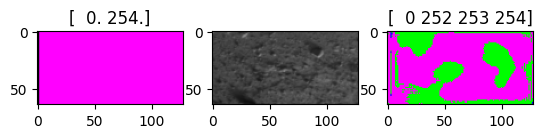

100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 0/250, val loss tensor([0.5800], device='cuda:0'), val metric tensor([0.1486, 0.1593, 0.2470, 0.4728, 0.5763], device='cuda:0')
Save best model best__unet++_xception.pt
Save last model last__unet++_xception_0.pt


100%|██████████| 98/98 [00:36<00:00,  2.69it/s]

Epoch 1/250, train loss tensor([0.5471], device='cuda:0'), train metric tensor([0.1393, 0.2637, 0.2999, 0.5396, 0.6872], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 1/250, val loss tensor([0.5505], device='cuda:0'), val metric tensor([0.1301, 0.3687, 0.3115, 0.5245, 0.5932], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 2/250, train loss tensor([0.5204], device='cuda:0'), train metric tensor([0.1406, 0.4267, 0.3394, 0.5802, 0.6945], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 2/250, val loss tensor([0.5249], device='cuda:0'), val metric tensor([0.1472, 0.4518, 0.3449, 0.6249, 0.7082], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:35<00:00,  2.78it/s]

Epoch 3/250, train loss tensor([0.5035], device='cuda:0'), train metric tensor([0.1362, 0.4803, 0.3869, 0.5870, 0.7030], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

Epoch 3/250, val loss tensor([0.6047], device='cuda:0'), val metric tensor([0.1631, 0.5635, 0.3905, 0.6041, 0.6927], device='cuda:0')



100%|██████████| 98/98 [00:37<00:00,  2.63it/s]

Epoch 4/250, train loss tensor([0.4964], device='cuda:0'), train metric tensor([0.1397, 0.5277, 0.4168, 0.6019, 0.6969], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 4/250, val loss tensor([0.4938], device='cuda:0'), val metric tensor([0.1318, 0.5138, 0.3675, 0.6292, 0.7114], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:36<00:00,  2.71it/s]

Epoch 5/250, train loss tensor([0.4850], device='cuda:0'), train metric tensor([0.1390, 0.5531, 0.4406, 0.6167, 0.6962], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 5/250, val loss tensor([0.5029], device='cuda:0'), val metric tensor([0.1332, 0.5986, 0.4522, 0.6269, 0.7090], device='cuda:0')


100%|██████████| 98/98 [00:35<00:00,  2.78it/s]

Epoch 6/250, train loss tensor([0.4752], device='cuda:0'), train metric tensor([0.1397, 0.5739, 0.5221, 0.6177, 0.7030], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 6/250, val loss tensor([0.4880], device='cuda:0'), val metric tensor([0.1381, 0.6866, 0.5138, 0.7008, 0.6989], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 7/250, train loss tensor([0.4621], device='cuda:0'), train metric tensor([0.1387, 0.6205, 0.5545, 0.6363, 0.6963], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 7/250, val loss tensor([0.6342], device='cuda:0'), val metric tensor([0.1349, 0.5797, 0.4255, 0.3964, 0.6722], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

Epoch 8/250, train loss tensor([0.4605], device='cuda:0'), train metric tensor([0.1365, 0.6395, 0.6138, 0.6467, 0.6854], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 8/250, val loss tensor([0.4608], device='cuda:0'), val metric tensor([0.1381, 0.6527, 0.6100, 0.6509, 0.6992], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:34<00:00,  2.83it/s]

Epoch 9/250, train loss tensor([0.4532], device='cuda:0'), train metric tensor([0.1387, 0.6421, 0.6317, 0.6551, 0.6790], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 9/250, val loss tensor([0.4490], device='cuda:0'), val metric tensor([0.1395, 0.7002, 0.5550, 0.7384, 0.6877], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:36<00:00,  2.67it/s]

Epoch 10/250, train loss tensor([0.4438], device='cuda:0'), train metric tensor([0.1387, 0.6411, 0.6441, 0.6569, 0.6762], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


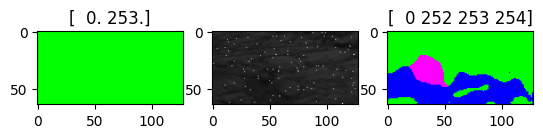

100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 10/250, val loss tensor([0.5158], device='cuda:0'), val metric tensor([0.1287, 0.6574, 0.4589, 0.4858, 0.6482], device='cuda:0')
Save last model last__unet++_xception_10.pt


100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 11/250, train loss tensor([0.4375], device='cuda:0'), train metric tensor([0.1419, 0.6598, 0.6583, 0.6650, 0.6911], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 11/250, val loss tensor([0.4423], device='cuda:0'), val metric tensor([0.1443, 0.6729, 0.6358, 0.6961, 0.6981], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:35<00:00,  2.74it/s]

Epoch 12/250, train loss tensor([0.4311], device='cuda:0'), train metric tensor([0.1358, 0.6668, 0.6719, 0.6673, 0.6830], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 12/250, val loss tensor([0.5116], device='cuda:0'), val metric tensor([0.1332, 0.6360, 0.5433, 0.6537, 0.7144], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 13/250, train loss tensor([0.4273], device='cuda:0'), train metric tensor([0.1358, 0.6773, 0.6610, 0.6725, 0.6889], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 13/250, val loss tensor([0.4380], device='cuda:0'), val metric tensor([0.1270, 0.7427, 0.6259, 0.6476, 0.6911], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:34<00:00,  2.83it/s]

Epoch 14/250, train loss tensor([0.4222], device='cuda:0'), train metric tensor([0.1368, 0.6872, 0.6738, 0.6954, 0.6898], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 14/250, val loss tensor([0.4220], device='cuda:0'), val metric tensor([0.1440, 0.6925, 0.6230, 0.6948, 0.6962], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:37<00:00,  2.59it/s]

Epoch 15/250, train loss tensor([0.4184], device='cuda:0'), train metric tensor([0.1397, 0.6955, 0.6805, 0.7044, 0.6925], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 15/250, val loss tensor([0.4682], device='cuda:0'), val metric tensor([0.1287, 0.7149, 0.5780, 0.6044, 0.7142], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.85it/s]

Epoch 16/250, train loss tensor([0.4086], device='cuda:0'), train metric tensor([0.1413, 0.7118, 0.6889, 0.7011, 0.6994], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 16/250, val loss tensor([0.4526], device='cuda:0'), val metric tensor([0.1381, 0.5924, 0.6444, 0.7366, 0.6953], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 17/250, train loss tensor([0.4082], device='cuda:0'), train metric tensor([0.1384, 0.7151, 0.6854, 0.7211, 0.6983], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 17/250, val loss tensor([0.4219], device='cuda:0'), val metric tensor([0.1318, 0.7919, 0.6294, 0.7146, 0.7149], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:35<00:00,  2.78it/s]

Epoch 18/250, train loss tensor([0.4016], device='cuda:0'), train metric tensor([0.1397, 0.7320, 0.6915, 0.7315, 0.7157], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

Epoch 18/250, val loss tensor([0.4587], device='cuda:0'), val metric tensor([0.1318, 0.7904, 0.5824, 0.6210, 0.7224], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.78it/s]

Epoch 19/250, train loss tensor([0.3990], device='cuda:0'), train metric tensor([0.1406, 0.7415, 0.7012, 0.7210, 0.7083], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 19/250, val loss tensor([0.4084], device='cuda:0'), val metric tensor([0.1287, 0.7373, 0.7006, 0.7438, 0.7427], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 20/250, train loss tensor([0.3983], device='cuda:0'), train metric tensor([0.1397, 0.7307, 0.7075, 0.7219, 0.7062], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


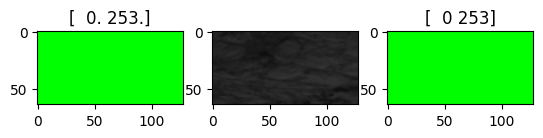

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 20/250, val loss tensor([0.3957], device='cuda:0'), val metric tensor([0.1332, 0.8077, 0.6723, 0.6760, 0.7077], device='cuda:0')
Save best model best__unet++_xception.pt
Save last model last__unet++_xception_20.pt


100%|██████████| 98/98 [00:36<00:00,  2.68it/s]

Epoch 21/250, train loss tensor([0.3891], device='cuda:0'), train metric tensor([0.1403, 0.7475, 0.7233, 0.7331, 0.7176], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

Epoch 21/250, val loss tensor([0.4043], device='cuda:0'), val metric tensor([0.1381, 0.7110, 0.6816, 0.7362, 0.7385], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 22/250, train loss tensor([0.3905], device='cuda:0'), train metric tensor([0.1409, 0.7372, 0.7185, 0.7431, 0.7232], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

Epoch 22/250, val loss tensor([0.3973], device='cuda:0'), val metric tensor([0.1426, 0.6869, 0.7292, 0.7875, 0.7328], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 23/250, train loss tensor([0.3857], device='cuda:0'), train metric tensor([0.1413, 0.7433, 0.7219, 0.7414, 0.7316], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 23/250, val loss tensor([0.3985], device='cuda:0'), val metric tensor([0.1287, 0.7464, 0.7221, 0.7485, 0.7721], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.83it/s]

Epoch 24/250, train loss tensor([0.3764], device='cuda:0'), train metric tensor([0.1387, 0.7482, 0.7368, 0.7539, 0.7289], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 24/250, val loss tensor([0.3883], device='cuda:0'), val metric tensor([0.1381, 0.7537, 0.7187, 0.7717, 0.7215], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 25/250, train loss tensor([0.3828], device='cuda:0'), train metric tensor([0.1378, 0.7346, 0.7419, 0.7399, 0.7418], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

Epoch 25/250, val loss tensor([0.4019], device='cuda:0'), val metric tensor([0.1318, 0.7849, 0.6933, 0.7170, 0.7363], device='cuda:0')



100%|██████████| 98/98 [00:37<00:00,  2.61it/s]

Epoch 26/250, train loss tensor([0.3788], device='cuda:0'), train metric tensor([0.1406, 0.7454, 0.7404, 0.7531, 0.7329], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

Epoch 26/250, val loss tensor([0.3902], device='cuda:0'), val metric tensor([0.1455, 0.7620, 0.7137, 0.7295, 0.7563], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.92it/s]

Epoch 27/250, train loss tensor([0.3721], device='cuda:0'), train metric tensor([0.1425, 0.7621, 0.7336, 0.7742, 0.7511], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 27/250, val loss tensor([0.4073], device='cuda:0'), val metric tensor([0.1457, 0.7741, 0.5805, 0.7264, 0.7245], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 28/250, train loss tensor([0.3724], device='cuda:0'), train metric tensor([0.1368, 0.7521, 0.7365, 0.7640, 0.7546], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

Epoch 28/250, val loss tensor([0.4877], device='cuda:0'), val metric tensor([0.1364, 0.7671, 0.6679, 0.5954, 0.7173], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.83it/s]

Epoch 29/250, train loss tensor([0.3732], device='cuda:0'), train metric tensor([0.1416, 0.7549, 0.7423, 0.7803, 0.7386], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 29/250, val loss tensor([0.3790], device='cuda:0'), val metric tensor([0.1395, 0.8060, 0.7423, 0.8338, 0.7804], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 30/250, train loss tensor([0.3654], device='cuda:0'), train metric tensor([0.1397, 0.7674, 0.7514, 0.7767, 0.7537], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


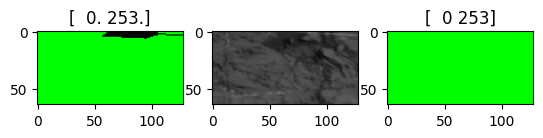

100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 30/250, val loss tensor([0.3983], device='cuda:0'), val metric tensor([0.1474, 0.7800, 0.6756, 0.7654, 0.7508], device='cuda:0')
Save last model last__unet++_xception_30.pt


100%|██████████| 98/98 [00:35<00:00,  2.73it/s]

Epoch 31/250, train loss tensor([0.3665], device='cuda:0'), train metric tensor([0.1419, 0.7580, 0.7538, 0.7759, 0.7583], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

Epoch 31/250, val loss tensor([0.3852], device='cuda:0'), val metric tensor([0.1318, 0.8118, 0.6694, 0.7818, 0.7464], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 32/250, train loss tensor([0.3639], device='cuda:0'), train metric tensor([0.1368, 0.7754, 0.7512, 0.7838, 0.7582], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

Epoch 32/250, val loss tensor([0.3869], device='cuda:0'), val metric tensor([0.1409, 0.7873, 0.7438, 0.7509, 0.7603], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 33/250, train loss tensor([0.3624], device='cuda:0'), train metric tensor([0.1371, 0.7738, 0.7517, 0.7819, 0.7513], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 33/250, val loss tensor([0.3758], device='cuda:0'), val metric tensor([0.1349, 0.8039, 0.7106, 0.7715, 0.7620], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:35<00:00,  2.76it/s]

Epoch 34/250, train loss tensor([0.3584], device='cuda:0'), train metric tensor([0.1390, 0.7758, 0.7635, 0.7744, 0.7570], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 34/250, val loss tensor([0.3793], device='cuda:0'), val metric tensor([0.1349, 0.8283, 0.7390, 0.8105, 0.7814], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 35/250, train loss tensor([0.3585], device='cuda:0'), train metric tensor([0.1429, 0.7795, 0.7614, 0.7897, 0.7646], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

Epoch 35/250, val loss tensor([0.4101], device='cuda:0'), val metric tensor([0.1381, 0.7735, 0.7061, 0.7321, 0.7846], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 36/250, train loss tensor([0.3571], device='cuda:0'), train metric tensor([0.1406, 0.7767, 0.7732, 0.7793, 0.7620], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

Epoch 36/250, val loss tensor([0.3778], device='cuda:0'), val metric tensor([0.1457, 0.7420, 0.7047, 0.7777, 0.7422], device='cuda:0')



100%|██████████| 98/98 [00:36<00:00,  2.72it/s]

Epoch 37/250, train loss tensor([0.3615], device='cuda:0'), train metric tensor([0.1381, 0.7633, 0.7717, 0.7832, 0.7753], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 37/250, val loss tensor([0.3613], device='cuda:0'), val metric tensor([0.1287, 0.8255, 0.7455, 0.8310, 0.8001], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:34<00:00,  2.82it/s]

Epoch 38/250, train loss tensor([0.3504], device='cuda:0'), train metric tensor([0.1365, 0.7942, 0.7729, 0.7878, 0.7853], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 38/250, val loss tensor([0.3629], device='cuda:0'), val metric tensor([0.1395, 0.8146, 0.7579, 0.7895, 0.7651], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 39/250, train loss tensor([0.3510], device='cuda:0'), train metric tensor([0.1381, 0.7871, 0.7768, 0.7916, 0.7821], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

Epoch 39/250, val loss tensor([0.3728], device='cuda:0'), val metric tensor([0.1318, 0.8119, 0.7403, 0.8016, 0.7899], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.79it/s]

Epoch 40/250, train loss tensor([0.3482], device='cuda:0'), train metric tensor([0.1409, 0.7932, 0.7742, 0.7977, 0.7761], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


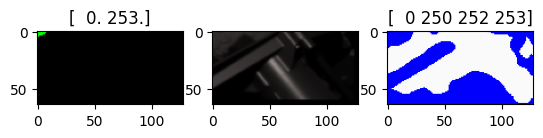

100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 40/250, val loss tensor([0.3938], device='cuda:0'), val metric tensor([0.1381, 0.7902, 0.7376, 0.8049, 0.7823], device='cuda:0')
Save last model last__unet++_xception_40.pt


100%|██████████| 98/98 [00:34<00:00,  2.81it/s]

Epoch 41/250, train loss tensor([0.3444], device='cuda:0'), train metric tensor([0.1371, 0.7867, 0.7789, 0.7978, 0.7854], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 41/250, val loss tensor([0.3599], device='cuda:0'), val metric tensor([0.1520, 0.8387, 0.7488, 0.7971, 0.8076], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:36<00:00,  2.71it/s]

Epoch 42/250, train loss tensor([0.3469], device='cuda:0'), train metric tensor([0.1403, 0.8024, 0.7766, 0.7950, 0.7829], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 42/250, val loss tensor([0.3929], device='cuda:0'), val metric tensor([0.1301, 0.7749, 0.7397, 0.7808, 0.7638], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.85it/s]

Epoch 43/250, train loss tensor([0.3411], device='cuda:0'), train metric tensor([0.1358, 0.8071, 0.7772, 0.8093, 0.7987], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

Epoch 43/250, val loss tensor([0.3693], device='cuda:0'), val metric tensor([0.1472, 0.8467, 0.7398, 0.7882, 0.7937], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.80it/s]

Epoch 44/250, train loss tensor([0.3514], device='cuda:0'), train metric tensor([0.1387, 0.7810, 0.7702, 0.7932, 0.7840], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 44/250, val loss tensor([0.3882], device='cuda:0'), val metric tensor([0.1503, 0.7742, 0.7334, 0.7843, 0.7578], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 45/250, train loss tensor([0.3438], device='cuda:0'), train metric tensor([0.1349, 0.7956, 0.7845, 0.8096, 0.8026], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 45/250, val loss tensor([0.3975], device='cuda:0'), val metric tensor([0.1409, 0.7932, 0.7313, 0.7484, 0.7890], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.91it/s]

Epoch 46/250, train loss tensor([0.3417], device='cuda:0'), train metric tensor([0.1387, 0.8059, 0.7829, 0.8078, 0.8042], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

Epoch 46/250, val loss tensor([0.3725], device='cuda:0'), val metric tensor([0.1426, 0.8311, 0.7321, 0.8072, 0.8086], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 47/250, train loss tensor([0.3438], device='cuda:0'), train metric tensor([0.1397, 0.7981, 0.7838, 0.7974, 0.7948], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

Epoch 47/250, val loss tensor([0.3661], device='cuda:0'), val metric tensor([0.1224, 0.7991, 0.7715, 0.8223, 0.7998], device='cuda:0')



100%|██████████| 98/98 [00:36<00:00,  2.72it/s]

Epoch 48/250, train loss tensor([0.3366], device='cuda:0'), train metric tensor([0.1365, 0.8126, 0.7937, 0.8176, 0.8073], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 48/250, val loss tensor([0.3674], device='cuda:0'), val metric tensor([0.1426, 0.8133, 0.7191, 0.8401, 0.8209], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 49/250, train loss tensor([0.3298], device='cuda:0'), train metric tensor([0.1371, 0.8199, 0.8041, 0.8252, 0.8190], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 49/250, val loss tensor([0.3737], device='cuda:0'), val metric tensor([0.1349, 0.8235, 0.7554, 0.8047, 0.8034], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.91it/s]

Epoch 50/250, train loss tensor([0.3388], device='cuda:0'), train metric tensor([0.1409, 0.8077, 0.7866, 0.8216, 0.8048], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


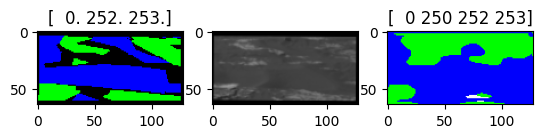

100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 50/250, val loss tensor([0.3576], device='cuda:0'), val metric tensor([0.1426, 0.8305, 0.7284, 0.7735, 0.8451], device='cuda:0')
Save best model best__unet++_xception.pt
Save last model last__unet++_xception_50.pt


100%|██████████| 98/98 [00:35<00:00,  2.73it/s]

Epoch 51/250, train loss tensor([0.3364], device='cuda:0'), train metric tensor([0.1346, 0.8150, 0.8059, 0.8123, 0.8134], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 51/250, val loss tensor([0.3624], device='cuda:0'), val metric tensor([0.1381, 0.8085, 0.7931, 0.7822, 0.8440], device='cuda:0')


100%|██████████| 98/98 [00:32<00:00,  2.97it/s]

Epoch 52/250, train loss tensor([0.3348], device='cuda:0'), train metric tensor([0.1371, 0.8038, 0.7931, 0.8213, 0.8248], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 52/250, val loss tensor([0.3720], device='cuda:0'), val metric tensor([0.1318, 0.8105, 0.7608, 0.8228, 0.8440], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.81it/s]

Epoch 53/250, train loss tensor([0.3333], device='cuda:0'), train metric tensor([0.1406, 0.8112, 0.7983, 0.8134, 0.8176], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 53/250, val loss tensor([0.3544], device='cuda:0'), val metric tensor([0.1457, 0.8399, 0.7567, 0.8337, 0.7948], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:34<00:00,  2.80it/s]

Epoch 54/250, train loss tensor([0.3325], device='cuda:0'), train metric tensor([0.1393, 0.8094, 0.8025, 0.8231, 0.8231], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 54/250, val loss tensor([0.3566], device='cuda:0'), val metric tensor([0.1457, 0.8587, 0.7981, 0.8231, 0.8371], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 55/250, train loss tensor([0.3312], device='cuda:0'), train metric tensor([0.1381, 0.8222, 0.8011, 0.8154, 0.8128], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 55/250, val loss tensor([0.3872], device='cuda:0'), val metric tensor([0.1443, 0.8187, 0.6998, 0.7510, 0.8142], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.92it/s]

Epoch 56/250, train loss tensor([0.3295], device='cuda:0'), train metric tensor([0.1425, 0.8084, 0.8052, 0.8169, 0.8197], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 56/250, val loss tensor([0.3729], device='cuda:0'), val metric tensor([0.1349, 0.8306, 0.7594, 0.7778, 0.8091], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 57/250, train loss tensor([0.3326], device='cuda:0'), train metric tensor([0.1381, 0.8173, 0.8062, 0.8205, 0.8261], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

Epoch 57/250, val loss tensor([0.3659], device='cuda:0'), val metric tensor([0.1381, 0.8186, 0.7702, 0.8112, 0.8596], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 58/250, train loss tensor([0.3278], device='cuda:0'), train metric tensor([0.1390, 0.8093, 0.8046, 0.8261, 0.8274], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 58/250, val loss tensor([0.3571], device='cuda:0'), val metric tensor([0.1426, 0.8389, 0.7420, 0.8224, 0.8267], device='cuda:0')


100%|██████████| 98/98 [00:35<00:00,  2.76it/s]

Epoch 59/250, train loss tensor([0.3276], device='cuda:0'), train metric tensor([0.1384, 0.8104, 0.8052, 0.8176, 0.8257], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 59/250, val loss tensor([0.4047], device='cuda:0'), val metric tensor([0.1349, 0.8015, 0.6817, 0.7203, 0.7898], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.93it/s]

Epoch 60/250, train loss tensor([0.3259], device='cuda:0'), train metric tensor([0.1362, 0.8133, 0.8014, 0.8303, 0.8342], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


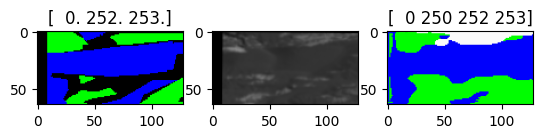

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 60/250, val loss tensor([0.3568], device='cuda:0'), val metric tensor([0.1256, 0.8421, 0.7616, 0.8387, 0.8487], device='cuda:0')
Save last model last__unet++_xception_60.pt


100%|██████████| 98/98 [00:35<00:00,  2.80it/s]

Epoch 61/250, train loss tensor([0.3312], device='cuda:0'), train metric tensor([0.1374, 0.8124, 0.8002, 0.8180, 0.8239], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 61/250, val loss tensor([0.3503], device='cuda:0'), val metric tensor([0.1381, 0.8439, 0.7663, 0.8398, 0.8429], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:35<00:00,  2.78it/s]

Epoch 62/250, train loss tensor([0.3270], device='cuda:0'), train metric tensor([0.1378, 0.8214, 0.8147, 0.8200, 0.8234], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 62/250, val loss tensor([0.3374], device='cuda:0'), val metric tensor([0.1256, 0.8737, 0.7703, 0.8085, 0.8751], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:35<00:00,  2.78it/s]

Epoch 63/250, train loss tensor([0.3232], device='cuda:0'), train metric tensor([0.1368, 0.8367, 0.8131, 0.8293, 0.8382], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 63/250, val loss tensor([0.3656], device='cuda:0'), val metric tensor([0.1318, 0.8368, 0.7853, 0.8427, 0.8559], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.92it/s]

Epoch 64/250, train loss tensor([0.3182], device='cuda:0'), train metric tensor([0.1390, 0.8339, 0.8172, 0.8227, 0.8418], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 64/250, val loss tensor([0.3870], device='cuda:0'), val metric tensor([0.1381, 0.8387, 0.7587, 0.7374, 0.8199], device='cuda:0')


100%|██████████| 98/98 [00:35<00:00,  2.77it/s]

Epoch 65/250, train loss tensor([0.3226], device='cuda:0'), train metric tensor([0.1378, 0.8315, 0.8192, 0.8243, 0.8454], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 65/250, val loss tensor([0.4003], device='cuda:0'), val metric tensor([0.1256, 0.7996, 0.7267, 0.7145, 0.8519], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 66/250, train loss tensor([0.3221], device='cuda:0'), train metric tensor([0.1381, 0.8374, 0.8159, 0.8351, 0.8496], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

Epoch 66/250, val loss tensor([0.3770], device='cuda:0'), val metric tensor([0.1378, 0.8326, 0.7660, 0.8180, 0.8714], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 67/250, train loss tensor([0.3199], device='cuda:0'), train metric tensor([0.1365, 0.8309, 0.8146, 0.8320, 0.8300], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 67/250, val loss tensor([0.3646], device='cuda:0'), val metric tensor([0.1318, 0.8503, 0.7432, 0.8019, 0.8352], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 68/250, train loss tensor([0.3222], device='cuda:0'), train metric tensor([0.1374, 0.8219, 0.8258, 0.8326, 0.8462], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 68/250, val loss tensor([0.3552], device='cuda:0'), val metric tensor([0.1412, 0.8546, 0.7778, 0.8573, 0.8752], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 69/250, train loss tensor([0.3189], device='cuda:0'), train metric tensor([0.1393, 0.8295, 0.8185, 0.8371, 0.8433], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

Epoch 69/250, val loss tensor([0.3639], device='cuda:0'), val metric tensor([0.1318, 0.8377, 0.7869, 0.8108, 0.8321], device='cuda:0')



100%|██████████| 98/98 [00:36<00:00,  2.65it/s]

Epoch 70/250, train loss tensor([0.3179], device='cuda:0'), train metric tensor([0.1387, 0.8340, 0.8185, 0.8405, 0.8496], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


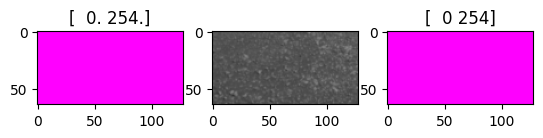

100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 70/250, val loss tensor([0.3572], device='cuda:0'), val metric tensor([0.1349, 0.8126, 0.7847, 0.8419, 0.8482], device='cuda:0')
Save last model last__unet++_xception_70.pt


100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 71/250, train loss tensor([0.3192], device='cuda:0'), train metric tensor([0.1393, 0.8260, 0.8167, 0.8426, 0.8432], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 71/250, val loss tensor([0.3500], device='cuda:0'), val metric tensor([0.1287, 0.8481, 0.7890, 0.8655, 0.8514], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 72/250, train loss tensor([0.3201], device='cuda:0'), train metric tensor([0.1349, 0.8251, 0.8129, 0.8381, 0.8419], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

Epoch 72/250, val loss tensor([0.3579], device='cuda:0'), val metric tensor([0.1301, 0.8448, 0.7714, 0.7606, 0.8008], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.77it/s]

Epoch 73/250, train loss tensor([0.3158], device='cuda:0'), train metric tensor([0.1403, 0.8276, 0.8160, 0.8411, 0.8595], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 73/250, val loss tensor([0.3496], device='cuda:0'), val metric tensor([0.1349, 0.8136, 0.7684, 0.8191, 0.8292], device='cuda:0')


100%|██████████| 98/98 [00:35<00:00,  2.77it/s]

Epoch 74/250, train loss tensor([0.3172], device='cuda:0'), train metric tensor([0.1378, 0.8368, 0.8123, 0.8355, 0.8535], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

Epoch 74/250, val loss tensor([0.3659], device='cuda:0'), val metric tensor([0.1318, 0.8206, 0.7826, 0.8246, 0.8722], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.96it/s]

Epoch 75/250, train loss tensor([0.3145], device='cuda:0'), train metric tensor([0.1368, 0.8378, 0.8180, 0.8508, 0.8571], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

Epoch 75/250, val loss tensor([0.3505], device='cuda:0'), val metric tensor([0.1349, 0.8523, 0.8000, 0.8641, 0.8389], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.74it/s]

Epoch 76/250, train loss tensor([0.3070], device='cuda:0'), train metric tensor([0.1387, 0.8481, 0.8301, 0.8494, 0.8608], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 76/250, val loss tensor([0.3665], device='cuda:0'), val metric tensor([0.1412, 0.8541, 0.7674, 0.7986, 0.8244], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 77/250, train loss tensor([0.3172], device='cuda:0'), train metric tensor([0.1352, 0.8392, 0.8234, 0.8450, 0.8560], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 77/250, val loss tensor([0.3797], device='cuda:0'), val metric tensor([0.1318, 0.8302, 0.7408, 0.8097, 0.8385], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 78/250, train loss tensor([0.3161], device='cuda:0'), train metric tensor([0.1374, 0.8383, 0.8209, 0.8490, 0.8558], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 78/250, val loss tensor([0.3482], device='cuda:0'), val metric tensor([0.1318, 0.8561, 0.7855, 0.8414, 0.8368], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 79/250, train loss tensor([0.3132], device='cuda:0'), train metric tensor([0.1362, 0.8423, 0.8251, 0.8498, 0.8668], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

Epoch 79/250, val loss tensor([0.3621], device='cuda:0'), val metric tensor([0.1412, 0.8429, 0.7717, 0.7919, 0.8836], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

Epoch 80/250, train loss tensor([0.3069], device='cuda:0'), train metric tensor([0.1368, 0.8476, 0.8431, 0.8554, 0.8682], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


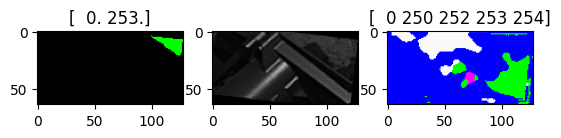

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 80/250, val loss tensor([0.3579], device='cuda:0'), val metric tensor([0.1349, 0.8261, 0.7656, 0.8156, 0.8734], device='cuda:0')
Save last model last__unet++_xception_80.pt


100%|██████████| 98/98 [00:34<00:00,  2.83it/s]

Epoch 81/250, train loss tensor([0.3118], device='cuda:0'), train metric tensor([0.1371, 0.8495, 0.8353, 0.8472, 0.8623], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

Epoch 81/250, val loss tensor([0.3561], device='cuda:0'), val metric tensor([0.1489, 0.8487, 0.7854, 0.8485, 0.8701], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.76it/s]

Epoch 82/250, train loss tensor([0.3089], device='cuda:0'), train metric tensor([0.1381, 0.8465, 0.8309, 0.8585, 0.8685], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 82/250, val loss tensor([0.3481], device='cuda:0'), val metric tensor([0.1256, 0.8520, 0.7884, 0.8086, 0.8613], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 83/250, train loss tensor([0.3056], device='cuda:0'), train metric tensor([0.1362, 0.8669, 0.8438, 0.8478, 0.8684], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 83/250, val loss tensor([0.3613], device='cuda:0'), val metric tensor([0.1287, 0.8616, 0.7922, 0.8380, 0.8188], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.94it/s]

Epoch 84/250, train loss tensor([0.3072], device='cuda:0'), train metric tensor([0.1358, 0.8586, 0.8396, 0.8503, 0.8696], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 84/250, val loss tensor([0.3698], device='cuda:0'), val metric tensor([0.1349, 0.8147, 0.7890, 0.7356, 0.8551], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

Epoch 85/250, train loss tensor([0.3070], device='cuda:0'), train metric tensor([0.1416, 0.8556, 0.8353, 0.8567, 0.8729], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

Epoch 85/250, val loss tensor([0.3864], device='cuda:0'), val metric tensor([0.1349, 0.8052, 0.7620, 0.8306, 0.8406], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 86/250, train loss tensor([0.3080], device='cuda:0'), train metric tensor([0.1397, 0.8433, 0.8315, 0.8528, 0.8793], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

Epoch 86/250, val loss tensor([0.3585], device='cuda:0'), val metric tensor([0.1349, 0.8371, 0.7804, 0.8429, 0.9001], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.74it/s]

Epoch 87/250, train loss tensor([0.3072], device='cuda:0'), train metric tensor([0.1393, 0.8529, 0.8314, 0.8487, 0.8620], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 87/250, val loss tensor([0.3588], device='cuda:0'), val metric tensor([0.1395, 0.8209, 0.7947, 0.8414, 0.8801], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.91it/s]

Epoch 88/250, train loss tensor([0.3012], device='cuda:0'), train metric tensor([0.1384, 0.8737, 0.8435, 0.8594, 0.8755], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

Epoch 88/250, val loss tensor([0.3886], device='cuda:0'), val metric tensor([0.1349, 0.8268, 0.7881, 0.7937, 0.8800], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

Epoch 89/250, train loss tensor([0.3076], device='cuda:0'), train metric tensor([0.1397, 0.8567, 0.8433, 0.8450, 0.8722], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 89/250, val loss tensor([0.3805], device='cuda:0'), val metric tensor([0.1506, 0.8069, 0.7510, 0.8425, 0.8684], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.96it/s]

Epoch 90/250, train loss tensor([0.3028], device='cuda:0'), train metric tensor([0.1384, 0.8499, 0.8473, 0.8676, 0.8736], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


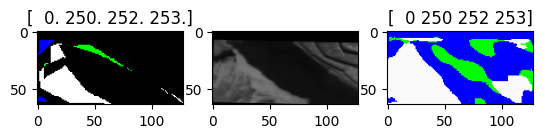

100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 90/250, val loss tensor([0.3310], device='cuda:0'), val metric tensor([0.1224, 0.8547, 0.8120, 0.8778, 0.8872], device='cuda:0')
Save best model best__unet++_xception.pt
Save last model last__unet++_xception_90.pt


100%|██████████| 98/98 [00:35<00:00,  2.73it/s]

Epoch 91/250, train loss tensor([0.3071], device='cuda:0'), train metric tensor([0.1384, 0.8501, 0.8406, 0.8579, 0.8715], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

Epoch 91/250, val loss tensor([0.3804], device='cuda:0'), val metric tensor([0.1409, 0.8137, 0.7611, 0.8425, 0.8355], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.81it/s]

Epoch 92/250, train loss tensor([0.3015], device='cuda:0'), train metric tensor([0.1378, 0.8586, 0.8361, 0.8638, 0.8743], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 92/250, val loss tensor([0.3787], device='cuda:0'), val metric tensor([0.1256, 0.8293, 0.7799, 0.8255, 0.8750], device='cuda:0')


100%|██████████| 98/98 [00:35<00:00,  2.73it/s]

Epoch 93/250, train loss tensor([0.3078], device='cuda:0'), train metric tensor([0.1352, 0.8496, 0.8362, 0.8515, 0.8730], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 93/250, val loss tensor([0.3579], device='cuda:0'), val metric tensor([0.1224, 0.8476, 0.7741, 0.8284, 0.8749], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 94/250, train loss tensor([0.3014], device='cuda:0'), train metric tensor([0.1374, 0.8632, 0.8496, 0.8623, 0.8752], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

Epoch 94/250, val loss tensor([0.3339], device='cuda:0'), val metric tensor([0.1381, 0.8245, 0.8002, 0.8399, 0.9146], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.80it/s]

Epoch 95/250, train loss tensor([0.3003], device='cuda:0'), train metric tensor([0.1390, 0.8595, 0.8411, 0.8641, 0.8744], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 95/250, val loss tensor([0.3366], device='cuda:0'), val metric tensor([0.1349, 0.8638, 0.7876, 0.8584, 0.8948], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.91it/s]

Epoch 96/250, train loss tensor([0.3023], device='cuda:0'), train metric tensor([0.1362, 0.8557, 0.8376, 0.8641, 0.8832], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 96/250, val loss tensor([0.3647], device='cuda:0'), val metric tensor([0.1349, 0.8307, 0.8119, 0.8616, 0.8924], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

Epoch 97/250, train loss tensor([0.3041], device='cuda:0'), train metric tensor([0.1390, 0.8598, 0.8444, 0.8556, 0.8809], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

Epoch 97/250, val loss tensor([0.3378], device='cuda:0'), val metric tensor([0.1395, 0.8398, 0.7958, 0.8746, 0.9108], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.77it/s]

Epoch 98/250, train loss tensor([0.2990], device='cuda:0'), train metric tensor([0.1413, 0.8668, 0.8467, 0.8624, 0.8890], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 98/250, val loss tensor([0.3349], device='cuda:0'), val metric tensor([0.1426, 0.8446, 0.7898, 0.8762, 0.9092], device='cuda:0')


100%|██████████| 98/98 [00:36<00:00,  2.68it/s]

Epoch 99/250, train loss tensor([0.2998], device='cuda:0'), train metric tensor([0.1416, 0.8686, 0.8459, 0.8670, 0.8910], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 99/250, val loss tensor([0.3482], device='cuda:0'), val metric tensor([0.1349, 0.8533, 0.7730, 0.8558, 0.8809], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

Epoch 100/250, train loss tensor([0.2951], device='cuda:0'), train metric tensor([0.1374, 0.8751, 0.8571, 0.8723, 0.8811], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


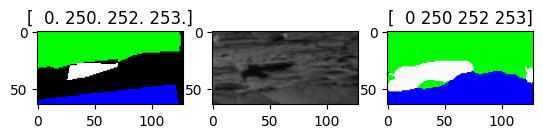

100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 100/250, val loss tensor([0.3650], device='cuda:0'), val metric tensor([0.1318, 0.8625, 0.7936, 0.8098, 0.8953], device='cuda:0')
Save last model last__unet++_xception_100.pt


100%|██████████| 98/98 [00:34<00:00,  2.81it/s]

Epoch 101/250, train loss tensor([0.2987], device='cuda:0'), train metric tensor([0.1400, 0.8717, 0.8522, 0.8704, 0.8726], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 101/250, val loss tensor([0.3384], device='cuda:0'), val metric tensor([0.1551, 0.8762, 0.7823, 0.8464, 0.8884], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.81it/s]

Epoch 102/250, train loss tensor([0.2952], device='cuda:0'), train metric tensor([0.1384, 0.8651, 0.8557, 0.8737, 0.8882], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

Epoch 102/250, val loss tensor([0.3474], device='cuda:0'), val metric tensor([0.1349, 0.8398, 0.7808, 0.8790, 0.8912], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 103/250, train loss tensor([0.2987], device='cuda:0'), train metric tensor([0.1371, 0.8602, 0.8565, 0.8753, 0.8918], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

Epoch 103/250, val loss tensor([0.3564], device='cuda:0'), val metric tensor([0.1506, 0.8415, 0.7942, 0.8531, 0.8908], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 104/250, train loss tensor([0.2953], device='cuda:0'), train metric tensor([0.1371, 0.8748, 0.8561, 0.8714, 0.8942], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 104/250, val loss tensor([0.3674], device='cuda:0'), val metric tensor([0.1364, 0.8418, 0.8031, 0.8871, 0.8952], device='cuda:0')


100%|██████████| 98/98 [00:35<00:00,  2.79it/s]

Epoch 105/250, train loss tensor([0.2932], device='cuda:0'), train metric tensor([0.1371, 0.8714, 0.8599, 0.8790, 0.8923], device='cuda:0')



100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

Epoch 105/250, val loss tensor([0.3678], device='cuda:0'), val metric tensor([0.1381, 0.8292, 0.8097, 0.8375, 0.9188], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 106/250, train loss tensor([0.2927], device='cuda:0'), train metric tensor([0.1378, 0.8814, 0.8543, 0.8771, 0.8942], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

Epoch 106/250, val loss tensor([0.3513], device='cuda:0'), val metric tensor([0.1318, 0.8100, 0.7794, 0.8468, 0.8842], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 107/250, train loss tensor([0.2963], device='cuda:0'), train metric tensor([0.1358, 0.8678, 0.8624, 0.8779, 0.8919], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

Epoch 107/250, val loss tensor([0.3532], device='cuda:0'), val metric tensor([0.1364, 0.8348, 0.7366, 0.8385, 0.9017], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 108/250, train loss tensor([0.2925], device='cuda:0'), train metric tensor([0.1400, 0.8714, 0.8530, 0.8805, 0.8912], device='cuda:0')



100%|██████████| 5/5 [00:05<00:00,  1.14s/it]

Epoch 108/250, val loss tensor([0.3494], device='cuda:0'), val metric tensor([0.1395, 0.8691, 0.8158, 0.8584, 0.9047], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 109/250, train loss tensor([0.2907], device='cuda:0'), train metric tensor([0.1403, 0.8868, 0.8649, 0.8805, 0.8996], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

Epoch 109/250, val loss tensor([0.3532], device='cuda:0'), val metric tensor([0.1193, 0.8511, 0.8081, 0.8812, 0.9040], device='cuda:0')



100%|██████████| 98/98 [00:36<00:00,  2.67it/s]

Epoch 110/250, train loss tensor([0.2923], device='cuda:0'), train metric tensor([0.1400, 0.8749, 0.8582, 0.8781, 0.9023], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


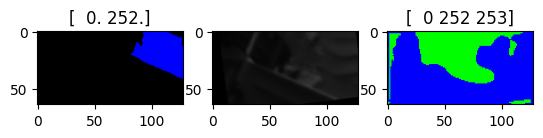

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 110/250, val loss tensor([0.3500], device='cuda:0'), val metric tensor([0.1349, 0.8526, 0.8020, 0.8851, 0.9003], device='cuda:0')
Save last model last__unet++_xception_110.pt


100%|██████████| 98/98 [00:34<00:00,  2.81it/s]

Epoch 111/250, train loss tensor([0.2924], device='cuda:0'), train metric tensor([0.1390, 0.8819, 0.8653, 0.8829, 0.8908], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 111/250, val loss tensor([0.3603], device='cuda:0'), val metric tensor([0.1301, 0.8105, 0.7918, 0.8618, 0.8805], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 112/250, train loss tensor([0.2924], device='cuda:0'), train metric tensor([0.1365, 0.8842, 0.8688, 0.8864, 0.8944], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 112/250, val loss tensor([0.3511], device='cuda:0'), val metric tensor([0.1364, 0.8664, 0.7830, 0.8559, 0.8841], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 113/250, train loss tensor([0.2928], device='cuda:0'), train metric tensor([0.1387, 0.8764, 0.8539, 0.8814, 0.8966], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

Epoch 113/250, val loss tensor([0.3416], device='cuda:0'), val metric tensor([0.1381, 0.8527, 0.8037, 0.8448, 0.9010], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.79it/s]

Epoch 114/250, train loss tensor([0.2858], device='cuda:0'), train metric tensor([0.1413, 0.8838, 0.8651, 0.8860, 0.9064], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 114/250, val loss tensor([0.3494], device='cuda:0'), val metric tensor([0.1318, 0.8232, 0.8071, 0.8493, 0.8955], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 115/250, train loss tensor([0.2916], device='cuda:0'), train metric tensor([0.1403, 0.8788, 0.8666, 0.8851, 0.8948], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 115/250, val loss tensor([0.3616], device='cuda:0'), val metric tensor([0.1332, 0.8256, 0.7463, 0.8645, 0.8766], device='cuda:0')


100%|██████████| 98/98 [00:35<00:00,  2.75it/s]

Epoch 116/250, train loss tensor([0.2976], device='cuda:0'), train metric tensor([0.1368, 0.8762, 0.8603, 0.8854, 0.8880], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

Epoch 116/250, val loss tensor([0.3906], device='cuda:0'), val metric tensor([0.1503, 0.8646, 0.7708, 0.7646, 0.8670], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 117/250, train loss tensor([0.2911], device='cuda:0'), train metric tensor([0.1400, 0.8802, 0.8625, 0.8804, 0.8864], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

Epoch 117/250, val loss tensor([0.3795], device='cuda:0'), val metric tensor([0.1364, 0.8080, 0.8111, 0.8692, 0.8596], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.92it/s]

Epoch 118/250, train loss tensor([0.2925], device='cuda:0'), train metric tensor([0.1403, 0.8883, 0.8649, 0.8832, 0.8958], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 118/250, val loss tensor([0.3582], device='cuda:0'), val metric tensor([0.1224, 0.8139, 0.7897, 0.8313, 0.8873], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.91it/s]

Epoch 119/250, train loss tensor([0.2896], device='cuda:0'), train metric tensor([0.1371, 0.8729, 0.8678, 0.8868, 0.9059], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 119/250, val loss tensor([0.3614], device='cuda:0'), val metric tensor([0.1287, 0.8341, 0.7922, 0.8667, 0.8982], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 120/250, train loss tensor([0.2925], device='cuda:0'), train metric tensor([0.1390, 0.8829, 0.8645, 0.8815, 0.8957], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


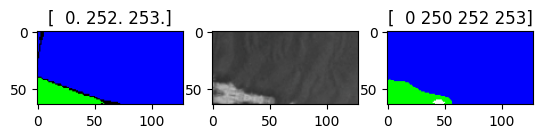

100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 120/250, val loss tensor([0.3655], device='cuda:0'), val metric tensor([0.1381, 0.8039, 0.8083, 0.8615, 0.9230], device='cuda:0')
Save last model last__unet++_xception_120.pt


100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

Epoch 121/250, train loss tensor([0.2875], device='cuda:0'), train metric tensor([0.1365, 0.8942, 0.8694, 0.8870, 0.9033], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 121/250, val loss tensor([0.3721], device='cuda:0'), val metric tensor([0.1349, 0.8348, 0.7998, 0.8756, 0.9201], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 122/250, train loss tensor([0.2895], device='cuda:0'), train metric tensor([0.1358, 0.8794, 0.8663, 0.8870, 0.8991], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 122/250, val loss tensor([0.3569], device='cuda:0'), val metric tensor([0.1287, 0.8586, 0.8262, 0.8681, 0.9067], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 123/250, train loss tensor([0.2879], device='cuda:0'), train metric tensor([0.1358, 0.8887, 0.8677, 0.8866, 0.9025], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

Epoch 123/250, val loss tensor([0.3492], device='cuda:0'), val metric tensor([0.1349, 0.8563, 0.8080, 0.8638, 0.9208], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.93it/s]

Epoch 124/250, train loss tensor([0.2856], device='cuda:0'), train metric tensor([0.1374, 0.8891, 0.8662, 0.8867, 0.9001], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

Epoch 124/250, val loss tensor([0.3747], device='cuda:0'), val metric tensor([0.1318, 0.8311, 0.7996, 0.8582, 0.9105], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.85it/s]

Epoch 125/250, train loss tensor([0.2897], device='cuda:0'), train metric tensor([0.1374, 0.8910, 0.8756, 0.8826, 0.9036], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 125/250, val loss tensor([0.3470], device='cuda:0'), val metric tensor([0.1582, 0.8258, 0.7966, 0.8398, 0.9233], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 126/250, train loss tensor([0.2840], device='cuda:0'), train metric tensor([0.1409, 0.8931, 0.8661, 0.8890, 0.9021], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

Epoch 126/250, val loss tensor([0.3509], device='cuda:0'), val metric tensor([0.1349, 0.8264, 0.8030, 0.8726, 0.9097], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 127/250, train loss tensor([0.2856], device='cuda:0'), train metric tensor([0.1371, 0.8976, 0.8811, 0.8900, 0.9069], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 127/250, val loss tensor([0.3613], device='cuda:0'), val metric tensor([0.1443, 0.8462, 0.7932, 0.8586, 0.8858], device='cuda:0')


100%|██████████| 98/98 [00:35<00:00,  2.76it/s]

Epoch 128/250, train loss tensor([0.2816], device='cuda:0'), train metric tensor([0.1365, 0.8990, 0.8759, 0.8916, 0.9034], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 128/250, val loss tensor([0.3616], device='cuda:0'), val metric tensor([0.1318, 0.8735, 0.8265, 0.8747, 0.9127], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 129/250, train loss tensor([0.2874], device='cuda:0'), train metric tensor([0.1365, 0.8874, 0.8729, 0.8965, 0.9053], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 129/250, val loss tensor([0.3752], device='cuda:0'), val metric tensor([0.1256, 0.8205, 0.7856, 0.8561, 0.8990], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.97it/s]

Epoch 130/250, train loss tensor([0.2859], device='cuda:0'), train metric tensor([0.1371, 0.8931, 0.8759, 0.8944, 0.9067], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


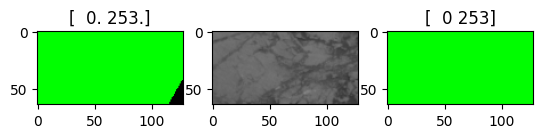

100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 130/250, val loss tensor([0.3772], device='cuda:0'), val metric tensor([0.1318, 0.8312, 0.7899, 0.8752, 0.8988], device='cuda:0')
Save last model last__unet++_xception_130.pt


100%|██████████| 98/98 [00:34<00:00,  2.81it/s]

Epoch 131/250, train loss tensor([0.2899], device='cuda:0'), train metric tensor([0.1419, 0.8879, 0.8747, 0.8904, 0.9043], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

Epoch 131/250, val loss tensor([0.3702], device='cuda:0'), val metric tensor([0.1443, 0.8361, 0.7368, 0.7775, 0.8856], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 132/250, train loss tensor([0.2879], device='cuda:0'), train metric tensor([0.1419, 0.8908, 0.8798, 0.8912, 0.9108], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 132/250, val loss tensor([0.3670], device='cuda:0'), val metric tensor([0.1412, 0.8177, 0.8082, 0.8338, 0.9048], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.93it/s]

Epoch 133/250, train loss tensor([0.2844], device='cuda:0'), train metric tensor([0.1374, 0.8932, 0.8832, 0.9030, 0.9175], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

Epoch 133/250, val loss tensor([0.3404], device='cuda:0'), val metric tensor([0.1256, 0.8396, 0.8332, 0.8740, 0.9122], device='cuda:0')



100%|██████████| 98/98 [00:38<00:00,  2.56it/s]

Epoch 134/250, train loss tensor([0.2815], device='cuda:0'), train metric tensor([0.1358, 0.8956, 0.8825, 0.8995, 0.9144], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 134/250, val loss tensor([0.3746], device='cuda:0'), val metric tensor([0.1503, 0.7760, 0.7918, 0.8461, 0.9031], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

Epoch 135/250, train loss tensor([0.2851], device='cuda:0'), train metric tensor([0.1406, 0.8985, 0.8768, 0.8940, 0.9122], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 135/250, val loss tensor([0.3427], device='cuda:0'), val metric tensor([0.1457, 0.8729, 0.8065, 0.8756, 0.9079], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 136/250, train loss tensor([0.2889], device='cuda:0'), train metric tensor([0.1371, 0.8866, 0.8771, 0.8965, 0.9121], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

Epoch 136/250, val loss tensor([0.3567], device='cuda:0'), val metric tensor([0.1349, 0.8512, 0.8333, 0.8740, 0.8915], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 137/250, train loss tensor([0.2831], device='cuda:0'), train metric tensor([0.1365, 0.8957, 0.8740, 0.8962, 0.9099], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 137/250, val loss tensor([0.3393], device='cuda:0'), val metric tensor([0.1426, 0.8423, 0.8307, 0.8806, 0.9040], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.91it/s]

Epoch 138/250, train loss tensor([0.2826], device='cuda:0'), train metric tensor([0.1365, 0.8880, 0.8841, 0.8970, 0.9158], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 138/250, val loss tensor([0.3574], device='cuda:0'), val metric tensor([0.1332, 0.8306, 0.8172, 0.8769, 0.9150], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.85it/s]

Epoch 139/250, train loss tensor([0.2822], device='cuda:0'), train metric tensor([0.1384, 0.8918, 0.8773, 0.9065, 0.9190], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

Epoch 139/250, val loss tensor([0.3669], device='cuda:0'), val metric tensor([0.1457, 0.8245, 0.8158, 0.8820, 0.9085], device='cuda:0')



100%|██████████| 98/98 [00:36<00:00,  2.67it/s]

Epoch 140/250, train loss tensor([0.2842], device='cuda:0'), train metric tensor([0.1374, 0.9024, 0.8776, 0.8975, 0.9164], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


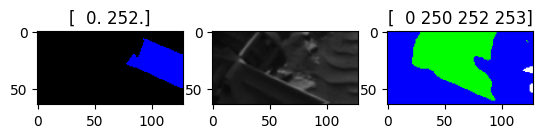

100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 140/250, val loss tensor([0.3520], device='cuda:0'), val metric tensor([0.1474, 0.8280, 0.8065, 0.8654, 0.9092], device='cuda:0')
Save last model last__unet++_xception_140.pt


100%|██████████| 98/98 [00:35<00:00,  2.76it/s]

Epoch 141/250, train loss tensor([0.2864], device='cuda:0'), train metric tensor([0.1393, 0.8982, 0.8712, 0.8973, 0.9062], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

Epoch 141/250, val loss tensor([0.3936], device='cuda:0'), val metric tensor([0.1472, 0.8248, 0.8179, 0.8748, 0.8959], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.92it/s]

Epoch 142/250, train loss tensor([0.2796], device='cuda:0'), train metric tensor([0.1374, 0.9024, 0.8823, 0.8997, 0.9154], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

Epoch 142/250, val loss tensor([0.3895], device='cuda:0'), val metric tensor([0.1349, 0.8430, 0.8280, 0.8679, 0.9110], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.82it/s]

Epoch 143/250, train loss tensor([0.2823], device='cuda:0'), train metric tensor([0.1393, 0.8956, 0.8850, 0.9027, 0.9143], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 143/250, val loss tensor([0.3364], device='cuda:0'), val metric tensor([0.1395, 0.8286, 0.8356, 0.8548, 0.9202], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.82it/s]

Epoch 144/250, train loss tensor([0.2859], device='cuda:0'), train metric tensor([0.1387, 0.9015, 0.8802, 0.9012, 0.9117], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 144/250, val loss tensor([0.3560], device='cuda:0'), val metric tensor([0.1287, 0.8485, 0.7831, 0.8644, 0.9311], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 145/250, train loss tensor([0.2787], device='cuda:0'), train metric tensor([0.1368, 0.9045, 0.8888, 0.9011, 0.9137], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

Epoch 145/250, val loss tensor([0.3726], device='cuda:0'), val metric tensor([0.1349, 0.8243, 0.8188, 0.8933, 0.9046], device='cuda:0')



100%|██████████| 98/98 [00:37<00:00,  2.62it/s]

Epoch 146/250, train loss tensor([0.2804], device='cuda:0'), train metric tensor([0.1365, 0.9057, 0.8943, 0.9032, 0.9199], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 146/250, val loss tensor([0.3439], device='cuda:0'), val metric tensor([0.1426, 0.8400, 0.8334, 0.8838, 0.9250], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 147/250, train loss tensor([0.2806], device='cuda:0'), train metric tensor([0.1342, 0.8977, 0.8858, 0.9071, 0.9201], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 147/250, val loss tensor([0.3636], device='cuda:0'), val metric tensor([0.1381, 0.8562, 0.8272, 0.8647, 0.9229], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.83it/s]

Epoch 148/250, train loss tensor([0.2764], device='cuda:0'), train metric tensor([0.1368, 0.9087, 0.8888, 0.9185, 0.9219], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

Epoch 148/250, val loss tensor([0.3531], device='cuda:0'), val metric tensor([0.1332, 0.8289, 0.8273, 0.8754, 0.9213], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 149/250, train loss tensor([0.2769], device='cuda:0'), train metric tensor([0.1413, 0.9075, 0.8931, 0.8988, 0.9123], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

Epoch 149/250, val loss tensor([0.3519], device='cuda:0'), val metric tensor([0.1381, 0.8500, 0.8009, 0.8508, 0.9067], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.92it/s]

Epoch 150/250, train loss tensor([0.2783], device='cuda:0'), train metric tensor([0.1387, 0.9045, 0.8880, 0.9042, 0.9203], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


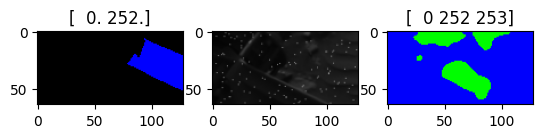

100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 150/250, val loss tensor([0.3412], device='cuda:0'), val metric tensor([0.1381, 0.8658, 0.8294, 0.8516, 0.9096], device='cuda:0')
Save last model last__unet++_xception_150.pt


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 151/250, train loss tensor([0.2797], device='cuda:0'), train metric tensor([0.1368, 0.9013, 0.8843, 0.8949, 0.9202], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

Epoch 151/250, val loss tensor([0.3624], device='cuda:0'), val metric tensor([0.1426, 0.8073, 0.8127, 0.8876, 0.9069], device='cuda:0')



100%|██████████| 98/98 [00:36<00:00,  2.66it/s]

Epoch 152/250, train loss tensor([0.2823], device='cuda:0'), train metric tensor([0.1378, 0.9029, 0.8879, 0.9016, 0.9183], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 152/250, val loss tensor([0.3349], device='cuda:0'), val metric tensor([0.1349, 0.8530, 0.7705, 0.8638, 0.9100], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.92it/s]

Epoch 153/250, train loss tensor([0.2805], device='cuda:0'), train metric tensor([0.1339, 0.8990, 0.8845, 0.9062, 0.9160], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

Epoch 153/250, val loss tensor([0.3519], device='cuda:0'), val metric tensor([0.1381, 0.8093, 0.8453, 0.8593, 0.9035], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 154/250, train loss tensor([0.2783], device='cuda:0'), train metric tensor([0.1381, 0.9070, 0.8886, 0.9102, 0.9140], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

Epoch 154/250, val loss tensor([0.3446], device='cuda:0'), val metric tensor([0.1349, 0.8098, 0.8096, 0.8797, 0.9101], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.85it/s]

Epoch 155/250, train loss tensor([0.2778], device='cuda:0'), train metric tensor([0.1371, 0.9056, 0.8953, 0.9089, 0.9214], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 155/250, val loss tensor([0.3534], device='cuda:0'), val metric tensor([0.1287, 0.8778, 0.8363, 0.8616, 0.9289], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

Epoch 156/250, train loss tensor([0.2806], device='cuda:0'), train metric tensor([0.1397, 0.9090, 0.8901, 0.9083, 0.9209], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 156/250, val loss tensor([0.3663], device='cuda:0'), val metric tensor([0.1364, 0.8424, 0.8206, 0.8440, 0.9155], device='cuda:0')


100%|██████████| 98/98 [00:32<00:00,  2.99it/s]

Epoch 157/250, train loss tensor([0.2757], device='cuda:0'), train metric tensor([0.1432, 0.9059, 0.8931, 0.9083, 0.9235], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

Epoch 157/250, val loss tensor([0.3643], device='cuda:0'), val metric tensor([0.1364, 0.8282, 0.8176, 0.8522, 0.9429], device='cuda:0')



100%|██████████| 98/98 [00:37<00:00,  2.62it/s]

Epoch 158/250, train loss tensor([0.2782], device='cuda:0'), train metric tensor([0.1378, 0.9027, 0.8914, 0.9055, 0.9206], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 158/250, val loss tensor([0.3782], device='cuda:0'), val metric tensor([0.1332, 0.8402, 0.8199, 0.8285, 0.9121], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.92it/s]

Epoch 159/250, train loss tensor([0.2773], device='cuda:0'), train metric tensor([0.1346, 0.9105, 0.8983, 0.9094, 0.9251], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 159/250, val loss tensor([0.3635], device='cuda:0'), val metric tensor([0.1301, 0.8279, 0.8079, 0.8835, 0.8966], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 160/250, train loss tensor([0.2776], device='cuda:0'), train metric tensor([0.1378, 0.9129, 0.8992, 0.9201, 0.9168], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


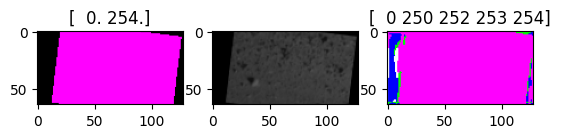

100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 160/250, val loss tensor([0.3670], device='cuda:0'), val metric tensor([0.1395, 0.8236, 0.8265, 0.8286, 0.9111], device='cuda:0')
Save last model last__unet++_xception_160.pt


100%|██████████| 98/98 [00:33<00:00,  2.94it/s]

Epoch 161/250, train loss tensor([0.2801], device='cuda:0'), train metric tensor([0.1390, 0.8968, 0.8950, 0.9060, 0.9227], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

Epoch 161/250, val loss tensor([0.3901], device='cuda:0'), val metric tensor([0.1287, 0.7612, 0.8094, 0.8635, 0.9261], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.93it/s]

Epoch 162/250, train loss tensor([0.2761], device='cuda:0'), train metric tensor([0.1403, 0.8991, 0.9020, 0.9070, 0.9268], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 162/250, val loss tensor([0.3483], device='cuda:0'), val metric tensor([0.1381, 0.8324, 0.8213, 0.8492, 0.9163], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 163/250, train loss tensor([0.2748], device='cuda:0'), train metric tensor([0.1362, 0.9146, 0.8956, 0.9206, 0.9256], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

Epoch 163/250, val loss tensor([0.3628], device='cuda:0'), val metric tensor([0.1349, 0.8501, 0.8468, 0.8836, 0.9174], device='cuda:0')



100%|██████████| 98/98 [00:37<00:00,  2.64it/s]

Epoch 164/250, train loss tensor([0.2732], device='cuda:0'), train metric tensor([0.1365, 0.9156, 0.8982, 0.9134, 0.9284], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 164/250, val loss tensor([0.3719], device='cuda:0'), val metric tensor([0.1349, 0.8595, 0.8316, 0.8624, 0.9264], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 165/250, train loss tensor([0.2719], device='cuda:0'), train metric tensor([0.1378, 0.9187, 0.9007, 0.9265, 0.9288], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

Epoch 165/250, val loss tensor([0.3623], device='cuda:0'), val metric tensor([0.1381, 0.8246, 0.8449, 0.8598, 0.9316], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.91it/s]

Epoch 166/250, train loss tensor([0.2750], device='cuda:0'), train metric tensor([0.1371, 0.9166, 0.9078, 0.9180, 0.9235], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

Epoch 166/250, val loss tensor([0.3521], device='cuda:0'), val metric tensor([0.1256, 0.8600, 0.8184, 0.8501, 0.9298], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 167/250, train loss tensor([0.2795], device='cuda:0'), train metric tensor([0.1384, 0.9076, 0.8938, 0.9035, 0.9260], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.25it/s]

Epoch 167/250, val loss tensor([0.3422], device='cuda:0'), val metric tensor([0.1318, 0.8561, 0.8313, 0.8684, 0.9320], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 168/250, train loss tensor([0.2758], device='cuda:0'), train metric tensor([0.1378, 0.9136, 0.8999, 0.9161, 0.9255], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 168/250, val loss tensor([0.3520], device='cuda:0'), val metric tensor([0.1412, 0.8487, 0.8225, 0.8634, 0.9116], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 169/250, train loss tensor([0.2752], device='cuda:0'), train metric tensor([0.1397, 0.9196, 0.8960, 0.9122, 0.9229], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

Epoch 169/250, val loss tensor([0.3578], device='cuda:0'), val metric tensor([0.1224, 0.8324, 0.8141, 0.8751, 0.9129], device='cuda:0')



100%|██████████| 98/98 [00:36<00:00,  2.71it/s]

Epoch 170/250, train loss tensor([0.2736], device='cuda:0'), train metric tensor([0.1400, 0.9229, 0.8975, 0.9221, 0.9278], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


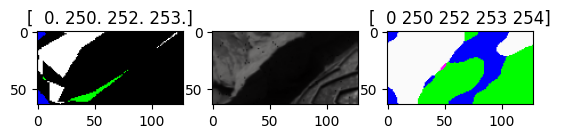

100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 170/250, val loss tensor([0.3591], device='cuda:0'), val metric tensor([0.1378, 0.8710, 0.8272, 0.8639, 0.9263], device='cuda:0')
Save last model last__unet++_xception_170.pt


100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 171/250, train loss tensor([0.2772], device='cuda:0'), train metric tensor([0.1413, 0.9095, 0.8967, 0.9161, 0.9303], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 171/250, val loss tensor([0.3343], device='cuda:0'), val metric tensor([0.1440, 0.8592, 0.8251, 0.8836, 0.9229], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 172/250, train loss tensor([0.2724], device='cuda:0'), train metric tensor([0.1429, 0.9167, 0.9063, 0.9175, 0.9293], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 172/250, val loss tensor([0.3714], device='cuda:0'), val metric tensor([0.1349, 0.8518, 0.8165, 0.8612, 0.9167], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.94it/s]

Epoch 173/250, train loss tensor([0.2800], device='cuda:0'), train metric tensor([0.1342, 0.9094, 0.8977, 0.9166, 0.9236], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

Epoch 173/250, val loss tensor([0.3346], device='cuda:0'), val metric tensor([0.1256, 0.8446, 0.8122, 0.8723, 0.9185], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 174/250, train loss tensor([0.2729], device='cuda:0'), train metric tensor([0.1378, 0.9145, 0.9005, 0.9159, 0.9293], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 174/250, val loss tensor([0.3271], device='cuda:0'), val metric tensor([0.1395, 0.8560, 0.8466, 0.8971, 0.9348], device='cuda:0')
Save best model best__unet++_xception.pt


100%|██████████| 98/98 [00:34<00:00,  2.82it/s]

Epoch 175/250, train loss tensor([0.2725], device='cuda:0'), train metric tensor([0.1403, 0.9227, 0.9008, 0.9158, 0.9298], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 175/250, val loss tensor([0.3465], device='cuda:0'), val metric tensor([0.1537, 0.8480, 0.8132, 0.8695, 0.9079], device='cuda:0')


100%|██████████| 98/98 [00:36<00:00,  2.65it/s]

Epoch 176/250, train loss tensor([0.2721], device='cuda:0'), train metric tensor([0.1397, 0.9182, 0.9069, 0.9181, 0.9280], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 176/250, val loss tensor([0.3514], device='cuda:0'), val metric tensor([0.1457, 0.8525, 0.8078, 0.8864, 0.9334], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 177/250, train loss tensor([0.2724], device='cuda:0'), train metric tensor([0.1368, 0.9144, 0.9026, 0.9220, 0.9269], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

Epoch 177/250, val loss tensor([0.3492], device='cuda:0'), val metric tensor([0.1412, 0.8419, 0.8303, 0.8739, 0.9199], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.95it/s]

Epoch 178/250, train loss tensor([0.2738], device='cuda:0'), train metric tensor([0.1384, 0.9175, 0.8958, 0.9200, 0.9259], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

Epoch 178/250, val loss tensor([0.3381], device='cuda:0'), val metric tensor([0.1287, 0.8548, 0.8252, 0.8853, 0.9345], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 179/250, train loss tensor([0.2760], device='cuda:0'), train metric tensor([0.1374, 0.9188, 0.8939, 0.9114, 0.9263], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 179/250, val loss tensor([0.3483], device='cuda:0'), val metric tensor([0.1474, 0.8336, 0.8482, 0.8542, 0.9114], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 180/250, train loss tensor([0.2737], device='cuda:0'), train metric tensor([0.1381, 0.9129, 0.9025, 0.9133, 0.9295], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


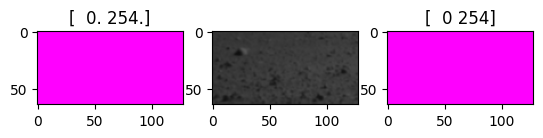

100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 180/250, val loss tensor([0.3546], device='cuda:0'), val metric tensor([0.1457, 0.8292, 0.8014, 0.9064, 0.9367], device='cuda:0')
Save last model last__unet++_xception_180.pt


100%|██████████| 98/98 [00:34<00:00,  2.85it/s]

Epoch 181/250, train loss tensor([0.2711], device='cuda:0'), train metric tensor([0.1387, 0.9223, 0.8998, 0.9199, 0.9336], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

Epoch 181/250, val loss tensor([0.3695], device='cuda:0'), val metric tensor([0.1534, 0.8164, 0.8292, 0.8863, 0.9183], device='cuda:0')



100%|██████████| 98/98 [00:36<00:00,  2.71it/s]

Epoch 182/250, train loss tensor([0.2715], device='cuda:0'), train metric tensor([0.1368, 0.9126, 0.9060, 0.9210, 0.9288], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 182/250, val loss tensor([0.3963], device='cuda:0'), val metric tensor([0.1381, 0.8232, 0.8113, 0.8669, 0.9219], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.86it/s]

Epoch 183/250, train loss tensor([0.2724], device='cuda:0'), train metric tensor([0.1400, 0.9206, 0.9048, 0.9134, 0.9304], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

Epoch 183/250, val loss tensor([0.3651], device='cuda:0'), val metric tensor([0.1381, 0.8437, 0.8234, 0.8837, 0.9235], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 184/250, train loss tensor([0.2743], device='cuda:0'), train metric tensor([0.1381, 0.9192, 0.9004, 0.9207, 0.9269], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

Epoch 184/250, val loss tensor([0.3458], device='cuda:0'), val metric tensor([0.1349, 0.8474, 0.8380, 0.8436, 0.9259], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 185/250, train loss tensor([0.2696], device='cuda:0'), train metric tensor([0.1403, 0.9271, 0.9088, 0.9207, 0.9302], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

Epoch 185/250, val loss tensor([0.3526], device='cuda:0'), val metric tensor([0.1364, 0.8502, 0.8464, 0.8660, 0.9170], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.94it/s]

Epoch 186/250, train loss tensor([0.2695], device='cuda:0'), train metric tensor([0.1374, 0.9224, 0.9123, 0.9248, 0.9353], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

Epoch 186/250, val loss tensor([0.3656], device='cuda:0'), val metric tensor([0.1349, 0.8429, 0.8249, 0.8895, 0.9252], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 187/250, train loss tensor([0.2677], device='cuda:0'), train metric tensor([0.1416, 0.9299, 0.9071, 0.9213, 0.9302], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 187/250, val loss tensor([0.3612], device='cuda:0'), val metric tensor([0.1364, 0.8227, 0.8364, 0.8869, 0.9261], device='cuda:0')


100%|██████████| 98/98 [00:35<00:00,  2.76it/s]

Epoch 188/250, train loss tensor([0.2717], device='cuda:0'), train metric tensor([0.1393, 0.9243, 0.9089, 0.9253, 0.9305], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

Epoch 188/250, val loss tensor([0.3587], device='cuda:0'), val metric tensor([0.1520, 0.8250, 0.8210, 0.8552, 0.9031], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.81it/s]

Epoch 189/250, train loss tensor([0.2724], device='cuda:0'), train metric tensor([0.1403, 0.9148, 0.9061, 0.9233, 0.9270], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 189/250, val loss tensor([0.3312], device='cuda:0'), val metric tensor([0.1349, 0.8399, 0.8243, 0.8564, 0.9217], device='cuda:0')


100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

Epoch 190/250, train loss tensor([0.2703], device='cuda:0'), train metric tensor([0.1368, 0.9239, 0.9140, 0.9204, 0.9281], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


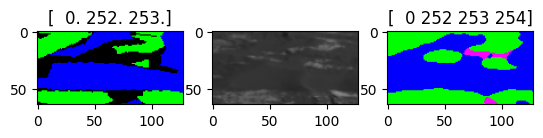

100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 190/250, val loss tensor([0.3390], device='cuda:0'), val metric tensor([0.1534, 0.8488, 0.8281, 0.8945, 0.9221], device='cuda:0')
Save last model last__unet++_xception_190.pt


100%|██████████| 98/98 [00:34<00:00,  2.82it/s]

Epoch 191/250, train loss tensor([0.2717], device='cuda:0'), train metric tensor([0.1406, 0.9232, 0.9061, 0.9249, 0.9272], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

Epoch 191/250, val loss tensor([0.3410], device='cuda:0'), val metric tensor([0.1440, 0.8575, 0.8212, 0.8686, 0.9153], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.83it/s]

Epoch 192/250, train loss tensor([0.2687], device='cuda:0'), train metric tensor([0.1374, 0.9225, 0.9041, 0.9208, 0.9308], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

Epoch 192/250, val loss tensor([0.3455], device='cuda:0'), val metric tensor([0.1318, 0.8503, 0.8258, 0.8666, 0.9247], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.88it/s]

Epoch 193/250, train loss tensor([0.2695], device='cuda:0'), train metric tensor([0.1409, 0.9290, 0.9116, 0.9231, 0.9319], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

Epoch 193/250, val loss tensor([0.3582], device='cuda:0'), val metric tensor([0.1489, 0.8188, 0.8468, 0.8644, 0.9404], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.80it/s]

Epoch 194/250, train loss tensor([0.2695], device='cuda:0'), train metric tensor([0.1365, 0.9238, 0.9130, 0.9312, 0.9399], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

Epoch 194/250, val loss tensor([0.3499], device='cuda:0'), val metric tensor([0.1426, 0.8515, 0.8450, 0.8893, 0.9382], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.89it/s]

Epoch 195/250, train loss tensor([0.2696], device='cuda:0'), train metric tensor([0.1374, 0.9242, 0.9106, 0.9267, 0.9403], device='cuda:0')



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

Epoch 195/250, val loss tensor([0.3606], device='cuda:0'), val metric tensor([0.1318, 0.8458, 0.8336, 0.9035, 0.9031], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.92it/s]

Epoch 196/250, train loss tensor([0.2682], device='cuda:0'), train metric tensor([0.1419, 0.9283, 0.9142, 0.9246, 0.9348], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

Epoch 196/250, val loss tensor([0.3553], device='cuda:0'), val metric tensor([0.1440, 0.8389, 0.8291, 0.8601, 0.9224], device='cuda:0')



100%|██████████| 98/98 [00:33<00:00,  2.93it/s]

Epoch 197/250, train loss tensor([0.2696], device='cuda:0'), train metric tensor([0.1374, 0.9219, 0.9092, 0.9174, 0.9288], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 197/250, val loss tensor([0.3713], device='cuda:0'), val metric tensor([0.1349, 0.8556, 0.8050, 0.8599, 0.9173], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 198/250, train loss tensor([0.2705], device='cuda:0'), train metric tensor([0.1362, 0.9315, 0.9120, 0.9280, 0.9346], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

Epoch 198/250, val loss tensor([0.3701], device='cuda:0'), val metric tensor([0.1412, 0.8409, 0.8187, 0.8577, 0.9187], device='cuda:0')



100%|██████████| 98/98 [00:35<00:00,  2.78it/s]

Epoch 199/250, train loss tensor([0.2691], device='cuda:0'), train metric tensor([0.1355, 0.9297, 0.9156, 0.9249, 0.9360], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 199/250, val loss tensor([0.3411], device='cuda:0'), val metric tensor([0.1287, 0.8349, 0.8318, 0.8961, 0.9268], device='cuda:0')


100%|██████████| 98/98 [00:36<00:00,  2.71it/s]

Epoch 200/250, train loss tensor([0.2695], device='cuda:0'), train metric tensor([0.1390, 0.9296, 0.9134, 0.9320, 0.9341], device='cuda:0')



  0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


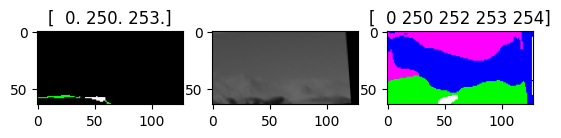

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 200/250, val loss tensor([0.3576], device='cuda:0'), val metric tensor([0.1349, 0.8273, 0.8390, 0.8894, 0.9489], device='cuda:0')
Save last model last__unet++_xception_200.pt


100%|██████████| 98/98 [00:34<00:00,  2.85it/s]

Epoch 201/250, train loss tensor([0.2669], device='cuda:0'), train metric tensor([0.1384, 0.9249, 0.9144, 0.9315, 0.9351], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 201/250, val loss tensor([0.3353], device='cuda:0'), val metric tensor([0.1301, 0.8509, 0.8149, 0.8851, 0.9278], device='cuda:0')


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]

Epoch 202/250, train loss tensor([0.2732], device='cuda:0'), train metric tensor([0.1378, 0.9254, 0.9088, 0.9224, 0.9369], device='cuda:0')



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

Epoch 202/250, val loss tensor([0.3690], device='cuda:0'), val metric tensor([0.1395, 0.8490, 0.8080, 0.8858, 0.9181], device='cuda:0')



100%|██████████| 98/98 [00:34<00:00,  2.84it/s]

Epoch 203/250, train loss tensor([0.2701], device='cuda:0'), train metric tensor([0.1317, 0.9328, 0.9161, 0.9231, 0.9397], device='cuda:0')



100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 203/250, val loss tensor([0.3540], device='cuda:0'), val metric tensor([0.1440, 0.8463, 0.8201, 0.9040, 0.9145], device='cuda:0')


 27%|██▋       | 26/98 [00:09<00:26,  2.74it/s]


KeyboardInterrupt: 

In [ ]:
training_process.run()

## Fine tune

In [ ]:
training_process = TrainingProcess(X, y, label_map_dict, color_map_dict, weights_inv, lr = 0.0001, encoder_name = "mobilenet_v2", model_type = "unet", model_weights = "last_unet_mobilenet_v2_200.pt")

In [ ]:
training_process.run()

## Eval

In [22]:
model_infer = smp.UnetPlusPlus(
                encoder_name = "xception",
                classes=5,
                encoder_weights=None,
                in_channels=3,
                activation=None,
            ).cuda()
model_infer.load_state_dict(torch.load("best__unet++_xception.pt", weights_only=True))
model_infer.eval()
None

In [23]:
model_infer2 = smp.UnetPlusPlus(
                encoder_name = "mobilenet_v2",
                classes=5,
                encoder_weights=None,
                in_channels=3,
                activation=None,
            ).cuda()
model_infer2.load_state_dict(torch.load("best_augm__unet++_mobilenet_v2.pt", weights_only=True))
model_infer2.eval()
None

In [25]:
model_infer3 = smp.Unet(
                encoder_name = "mobilenet_v2",
                classes=5,
                encoder_weights=None,
                in_channels=3,
                activation=None,
            ).cuda()
model_infer3.load_state_dict(torch.load("64_128_best_mobilenet_v2.pt", weights_only=True))
model_infer3.eval()
None

In [30]:
model_infer4 = smp.PSPNet(
                encoder_name = "mobilenet_v2",
                classes=5,
                encoder_weights=None,
                in_channels=3,
                activation=None,
            ).cuda()
model_infer4.load_state_dict(torch.load("best__pspnet_mobilenet_v2.pt", weights_only=True))
model_infer4.eval()
None

In [36]:
model_infer5 = smp.Unet(
                encoder_name = "inceptionresnetv2",
                classes=5,
                encoder_weights=None,
                in_channels=3,
                activation=None,
            ).cuda()
model_infer5.load_state_dict(torch.load("best_inceptionresnetv2_crossentropy.pt", weights_only=True, map_location="cpu"))
model_infer5.eval()
None

In [34]:
test_dataset = MarsSurface("test", X_test, X_test, label_map_dict, color_map_dict)
# test_dataset = MarsSurface("test", X_new, y_new, label_map_dict, color_map_dict)

test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=1,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
    )

In [37]:
pbar = tqdm(enumerate(test_loader), total=len(test_loader), dynamic_ncols=True)
preds = []
with torch.no_grad():
  for i, (inputs, masks, zero_mask, label ) in pbar:
        out = model_infer(inputs.cuda()) + model_infer2(inputs.cuda())+ model_infer3(inputs.cuda())+ model_infer4(inputs.cuda())+ model_infer5(inputs.cuda())
        preds.append(out)

100%|██████████| 10022/10022 [13:32<00:00, 12.33it/s]


In [38]:
import torch
torch.cuda.empty_cache()

In [39]:
import pandas as pd
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [40]:
preds[0].shape

pred_reshaped = torch.stack(preds, dim=0).squeeze(1).permute(0,2,3,1).cpu().detach().numpy()
pred_reshaped.shape
pred_label = np.argmax(pred_reshaped, axis=-1)
pred_label.shape

(10022, 64, 128)

In [41]:
# Create and download the csv submission file
submission_filename = f"submission_5_mod.csv"
submission_df = y_to_df(pred_label)
submission_df.to_csv(submission_filename, index=False)

In [ ]:
def show_inference(model_infer, model_infer2, model_infer3, idx, test_dataset):
  image, mask, zero_mask, label = test_dataset[idx]

  plt.subplot(231)
  plt.imshow(image.permute(1,2,0))

  out1 = model_infer(image.cuda().unsqueeze(0)).squeeze(0).permute(1,2,0).cpu().detach().numpy()

  pred_label1 = np.argmax(out1, axis=-1)
  pred_label1 = decode_mask_from_color_map(encode_label_from_label_map(pred_label1, label_map_dict), color_map_dict)

  plt.subplot(232)
  plt.title("Model 64x128")
  plt.imshow(pred_label1)

  out2 = model_infer2(image.cuda().unsqueeze(0)).squeeze(0).permute(1,2,0).cpu().detach().numpy()

  pred_label2 = np.argmax(out2, axis=-1)
  pred_label2 = decode_mask_from_color_map(encode_label_from_label_map(pred_label2, label_map_dict), color_map_dict)

  plt.subplot(233)
  plt.title("Model 32x64")

  plt.imshow(pred_label2)

  out3 = model_infer3(image.cuda().unsqueeze(0)).squeeze(0).permute(1,2,0).cpu().detach().numpy()

  pred_label3= np.argmax(out3, axis=-1)
  pred_label3 = decode_mask_from_color_map(encode_label_from_label_map(pred_label3, label_map_dict), color_map_dict)

  plt.subplot(234)
  plt.title("Model 16x32")

  plt.imshow(pred_label3)

  out_all = np.max(out1,out2,out3)
  pred_label_all= np.argmax(out_all, axis=-1)
  pred_label_all = decode_mask_from_color_map(encode_label_from_label_map(pred_label_all, label_map_dict), color_map_dict)

  plt.subplot(235)
  plt.title("Average")
  plt.imshow(pred_label_all)


  plt.subplot(236)
  plt.imshow(label.permute(1,2,0))


show_inference(model_infer, model_infer2, model_infer3, 1679,  test_dataset)